In [1]:
import dgl
import torch
import matplotlib.pyplot as plt
import networkx as nx
from dgl.nn import GraphConv
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F


Using backend: pytorch


In [2]:
u, v = torch.tensor([0,1,2,3,4,5,6,7,0,3,4,6]), torch.tensor([1,2,3,4,5,6,7,0,4,6,7,0])

In [3]:
g = dgl.graph((u, v))
print('g:')
print(g)
print('Node ID:')
print(g.nodes())
print('Edges:')
print('(default): The returned result is a 2-tuple of 1D tensors (U,V), representing the source and destination nodes of all edges. For each i, (U[i],V[i]) forms an edge.')
print(g.edges())
print('(all): The returned result is a 3-tuple of 1D tensors (U,V,EID), representing the source nodes, destination nodes and IDs of all edges. For each i, (U[i],V[i]) forms an edge with ID EID[i].')
print(g.edges(form='all'))

g = dgl.graph((u, v), num_nodes=8)

g:
Graph(num_nodes=8, num_edges=12,
      ndata_schemes={}
      edata_schemes={})
Node ID:
tensor([0, 1, 2, 3, 4, 5, 6, 7])
Edges:
(default): The returned result is a 2-tuple of 1D tensors (U,V), representing the source and destination nodes of all edges. For each i, (U[i],V[i]) forms an edge.
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 3, 4, 6]), tensor([1, 2, 3, 4, 5, 6, 7, 0, 4, 6, 7, 0]))
(all): The returned result is a 3-tuple of 1D tensors (U,V,EID), representing the source nodes, destination nodes and IDs of all edges. For each i, (U[i],V[i]) forms an edge with ID EID[i].
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 3, 4, 6]), tensor([1, 2, 3, 4, 5, 6, 7, 0, 4, 6, 7, 0]), tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))


In [4]:
bg = dgl.to_bidirected(g)
bg.edges()

(tensor([0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, 7]),
 tensor([1, 4, 6, 7, 0, 2, 1, 3, 2, 4, 6, 0, 3, 5, 7, 4, 6, 0, 3, 5, 7, 0, 4, 6]))

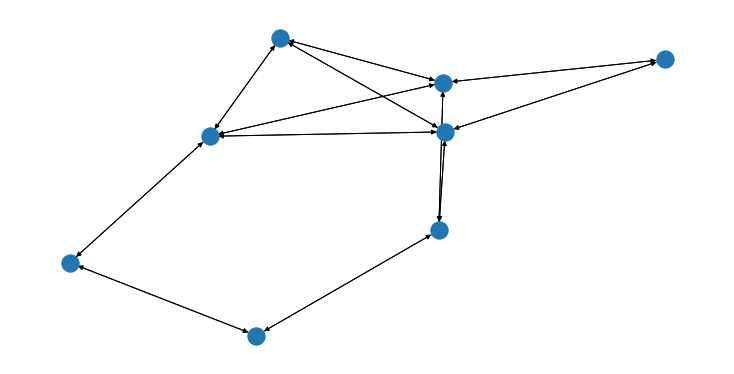

In [5]:
G = dgl.to_networkx(bg)
plt.figure(figsize=[10,5])
nx.draw(G)

In [6]:
bg.ndata['x'] = torch.zeros(bg.num_nodes(), 1)               # node feature
bg.ndata['x'][0] =   10
bg.ndata['x'][3] =   4
bg.ndata['x'][4] =   9
bg.ndata['x'][5] =   3
print(bg.ndata['x'])

tensor([[10.],
        [ 0.],
        [ 0.],
        [ 4.],
        [ 9.],
        [ 3.],
        [ 0.],
        [ 0.]])


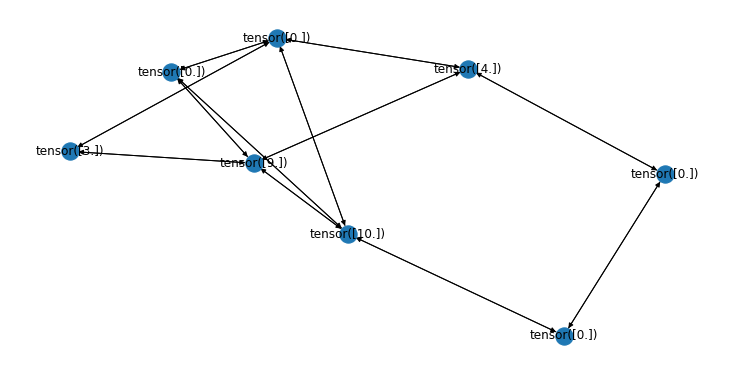

In [7]:
G = dgl.to_networkx(bg)
mapping = dict(zip(G, bg.ndata['x']))
G = nx.relabel_nodes(G, mapping)
plt.figure(figsize=[10,5])
nx.draw(G, with_labels=True)

Feature vector:
tensor([[10,  0,  0,  4,  9,  3,  0,  0]])
output:
tensor([[0.0814, 0.0428, 0.0555, 0.0629, 0.0729, 0.0571, 0.0729, 0.0653]],
       grad_fn=<PermuteBackward0>)
[0.08138636 0.04284992 0.05547328 0.06288528 0.07289508 0.05706641
 0.07289508 0.06529059]


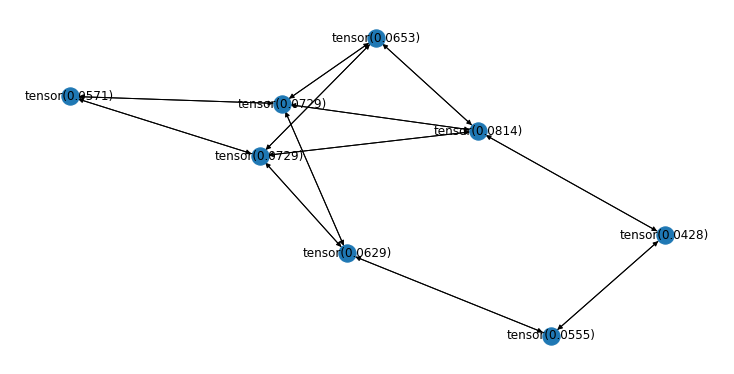

In [8]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.conv3 = GraphConv(h_feats, h_feats)
        self.conv4 = GraphConv(h_feats, 1)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g, h)
        h = F.relu(h)
        h = self.conv4(g, h)
        return h

model = GCN(1, 10)
print('Feature vector:')
print(bg.ndata['x'].long().T)
logits = model(bg, bg.ndata['x'].long())
print('output:')
print(logits.T)
G = dgl.to_networkx(bg)
print(logits.T[0].detach().numpy())
mapping = dict(zip(G, logits.T[0].detach()))
G = nx.relabel_nodes(G, mapping)
plt.figure(figsize=[10,5])
nx.draw(G, with_labels=True)

In [9]:

import torch
from torch_geometric.data import Dataset, download_url

import dgl
from dgl.data import DGLDataset
import torch
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

grid = pd.read_csv('grid.csv')

class GridDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    def process(self):
        nodes_data = grid
        edges_data = edges
        node_features = torch.from_numpy(nodes_data['reward'].to_numpy())
        #node_labels = torch.from_numpy(nodes_data['Club'].astype('category').cat.codes.to_numpy())
        edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
        edges_src = torch.from_numpy(edges_data['out'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['in'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        #self.graph.ndata['label'] = node_labels
        #self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = GridDataset('o')
graph = dataset[0]

print(graph)
print(graph.ndata)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


NotImplementedError: 